<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/SpectrumEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectrum Estimation

## Illustration of bias of the periodogram estimate

The periodogram is biased dependent on the available length of the measurement. The bias can be thought of as being introduced by the convolution of the the Fourier transform of a rectangular window (i.e., a sinc function) with the true spectrum

In [1]:
import numpy as np
import pylab as pl

# Setting it so figs will be a bit bigger
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.33]
plt.rcParams['figure.dpi']  = 120

In [2]:
fs = 1024
Nsamps = 256  # 0.25 seconds

In [3]:
from scipy import signal
nfilt = 64
cutoff = fs/5
h = signal.firwin(nfilt, cutoff, pass_zero='lowpass', fs=fs)

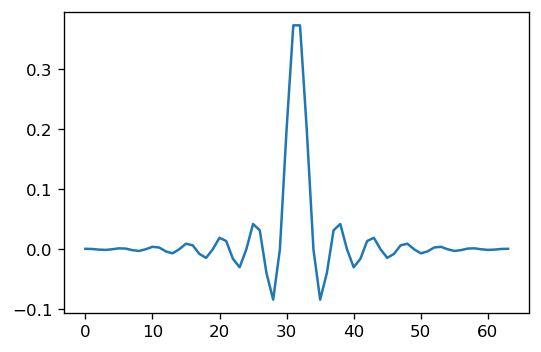

In [4]:
pl.plot(h)

In [5]:
Nfft = Nsamps
H = np.fft.fft(h, n=Nfft)
f = np.arange(0, Nfft) * fs / Nfft
H = H[f < fs/2]
S_true = np.abs(H) ** 2
S_true /= S_true.sum()


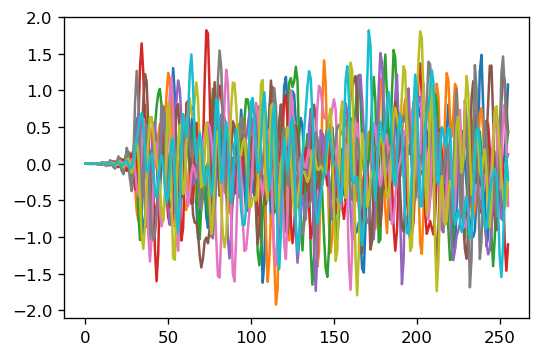

In [6]:
# Filter white noise through H
Ntrials = 10
noise = np.random.randn(Nsamps, Ntrials)
x = signal.lfilter(h, 1, noise, axis=0)
pl.plot(x)

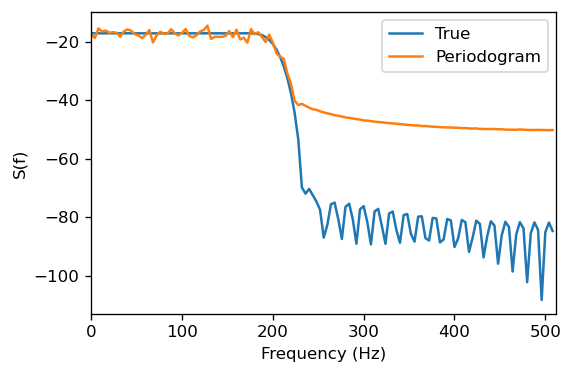

In [7]:
# Get periodogram
X = np.fft.fft(x, Nfft, axis=0)
f = np.arange(0, Nfft) * fs/Nfft
X = X[f < fs/2]
S_periodogram = (np.abs(X) ** 2).mean(axis=1) / Nfft
S_periodogram /= S_periodogram.sum()
f = f[f < fs/2]
pl.plot(f, 10 * np.log10(S_true))
pl.plot(f, 10 * np.log10(S_periodogram))
pl.xlim((0, fs/2))
pl.xlabel('Frequency (Hz)')
pl.ylabel('S(f)')
pl.legend(('True', 'Periodogram'))


## Tapering to reduce bias from far-away frequencies

In [8]:
w = signal.windows.hann(Nsamps)

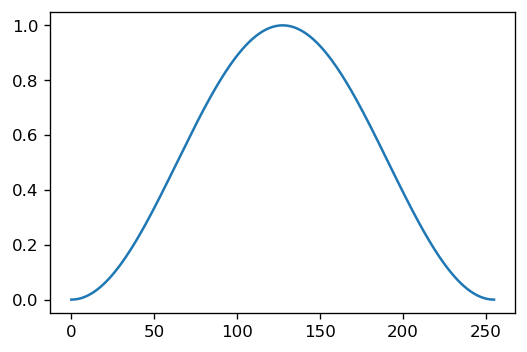

In [9]:
pl.plot(w)

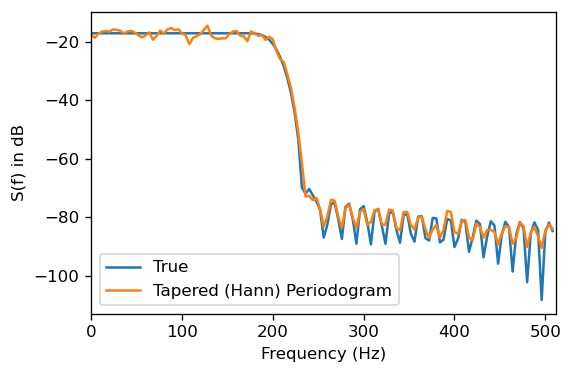

In [10]:
# Get tapered periodogram
X = np.fft.fft(x * w[:, None], Nfft, axis=0)
f = np.arange(0, Nfft) * fs/Nfft
X = X[f < fs/2]
f = f[f < fs/2]
S_periodogram_tapered = (np.abs(X) ** 2).mean(axis=1)
S_periodogram_tapered /= S_periodogram_tapered.sum()
pl.plot(f, 10 * np.log10(S_true))
pl.plot(f, 10 * np.log10(S_periodogram_tapered))
pl.xlim((0, fs/2))
pl.xlabel('Frequency (Hz)')
pl.ylabel('S(f) in dB')
pl.legend(('True', 'Tapered (Hann) Periodogram'))


## Example signal from Babadi & Brown (2014)

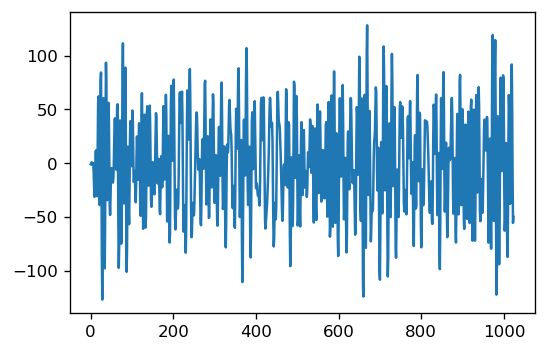

In [11]:
fs = 1024
N = 1024  # 1 second duration
e = np.random.randn(N)

# This is an AR(6) process so we initialize 6 samples with noisN
x = np.zeros(N)
x[:6] = e[:6] 

# Note that AR coefficients are in "samples" units, not seconds
for k in range(7, N):
    x[k] = 3.9515*x[k-1] - 7.8885*x[k-2] + 9.734*x[k-3] - 7.7435*x[k-4] + 3.8078*x[k-5] - 0.9472*x[k-6] + e[k];

pl.plot(x)

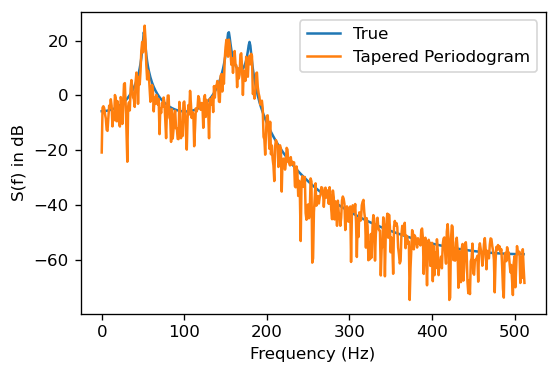

In [12]:
h_ar = np.asarray([1, -3.9515, 7.8885, -9.734, 7.7435, -3.8078, 0.9472])
Nfft = N
H = np.fft.fft(h_ar, n=Nfft)
f = np.arange(0, Nfft) * fs/Nfft
H = H[f < fs/2]
f = f[f < fs/2]
S_true =  2 * 1 / (np.abs(H) ** 2) / Nfft

pl.plot(f, 10*np.log10(S_true))

# Tapered periodogram
f, S_periodogram = signal.periodogram(x, window='hann', fs=fs)
pl.plot(f, 10*np.log10(S_periodogram))
pl.xlabel('Frequency (Hz)')
pl.ylabel('S(f) in dB')
pl.legend(('True', 'Tapered Periodogram'))


## Variance reduction (but bias increase) via the Welch method

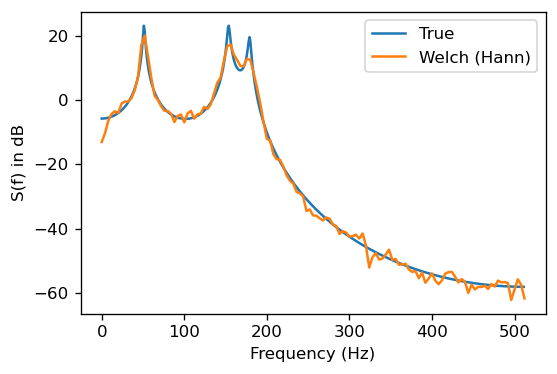

In [13]:
h_ar = np.asarray([1, -3.9515, 7.8885, -9.734, 7.7435, -3.8078, 0.9472])
Nfft = N
H = np.fft.fft(h_ar, n=Nfft)
f = np.arange(0, Nfft) * fs/Nfft
H = H[f < fs/2]
f = f[f < fs/2]
S_true = 2 * 1 / (np.abs(H) ** 2) / Nfft

pl.plot(f, 10*np.log10(S_true))
f, S_welch = signal.welch(x, window='hann', nperseg=N/4, fs=fs)
pl.plot(f, 10*np.log10(S_welch))
pl.xlabel('Frequency (Hz)')
pl.ylabel('S(f) in dB')
pl.legend(('True', 'Welch (Hann)'))
